In [ ]:
#hide
from fastai2.data.all import *
from nbdev.showdoc import show_doc

# Data block tutorial

> Using the data block accross all applications

In this tutorial, we'll see how to use the data block API on a variety of tasks and how to debug data blocks. The data block API takes its name from the way it's designed: every bit needed to build the `DataLoaders` object (type of inputs, targets, how to label, split...) is encapsulated in a block, and you can mix and match those blocks 

## Building a `DataBlock` from scratch

The rest of this tutorial will give many examples, but let's first build a `DataBlock` from scratch on the dogs versus cats problem we saw in the [vision tutorial](http://dev.fast.ai/tutorial.vision). First we import everything needed in vision.

In [ ]:
from fastai2.vision.all import *

The first step is to download and decompress our data (if it's not already done) and get its location:

In [ ]:
path = untar_data(URLs.PETS)

And as we saw, all the filenames are in the "images" folder. The `get_image_files` function helps get all the images in subfolders:

In [ ]:
fnames = get_image_files(path/"images")

Let's begin with an empty `DataBlock`.

In [ ]:
dblock = DataBlock()

By itself, a `DataBlock` is just a blue print on how to assemble your data. It does not do anything until you pass it a source. You can choose to then convert that source into a `Datasets` or a `DataLoaders` by using the `DataBlock.datasets` or `DataBlock.dataloaders` method. Since we haven't done anything to get our data ready for batches, the `dataloaders` method will fail here, but we can have a look at how it gets converted in `Datasets`. This is where we pass the source of our data, here all our filenames:

In [ ]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_26.jpg'),
 Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_26.jpg'))

By default, the data block API assumes we have an input and a target, which is why we see our filename repeated twice. 

The first thing we can do is use a `get_items` function to actually assemble our items inside the data block:

In [ ]:
dblock = DataBlock(get_items = get_image_files)

The difference is that you then pass as a source the folder with the images and not all the filenames:

In [ ]:
dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/Russian_Blue_99.jpg'),
 Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/Russian_Blue_99.jpg'))

Our inputs are ready to be processed as images (since images can be built from filenames), but our target is not. Since we are in a cat versus dog problem, we need to convert that filename to "cat" vs "dog" (or `True` vs `False`). Let's build a function for this:

In [ ]:
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

We can then tell our data block to use it to label our target by passing it as `get_y`:

In [ ]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/home/sgugger/.fastai/data/oxford-iiit-pet/images/shiba_inu_88.jpg'),
 'dog')

Now that our inputs and targets are ready, we can specify types to tell the data block API that our inputs are images and our targets are categories. Types are represented by blocks in the data block API, here we use `ImageBlock` and `CategoryBlock`:

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=500x400, TensorCategory(1))

We can see how the `DataBlock` automatically added the transforms necessary to open the image, or how it changed the name "cat" to an index (with a special tensor type). To do this, it created a mapping from categories to index called "vocab" that we can access this way:

In [ ]:
dsets.vocab

(#2) ['cat','dog']

Note that you can mix and match any block for input and targets, which is why the API is named data block API. You can also have more than two blocks (if you have multiple inputs and/or targets), you would just need to pass `n_inp` to the `DataBlock` to tell the library how many inputs there are (the rest would be targets) and pass a list of functions to `get_x` and/or `get_y` (to explain how to process each item to be ready for his type). See the object detection below for such an example.

The next step is to control how our validation set is created. We do this by passing a `splitter` to `DataBlock`. For instance, here is how to do a random split.

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter())

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=500x375, TensorCategory(1))

The last step is to specify item transforms and batch transforms (the same way we do it in `ImageDataLoaders` factory methods):

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

With that resize, we are now able to batch items together and can finally call `dataloaders` to convert our `DataBlock` to a `DataLoaders` object:

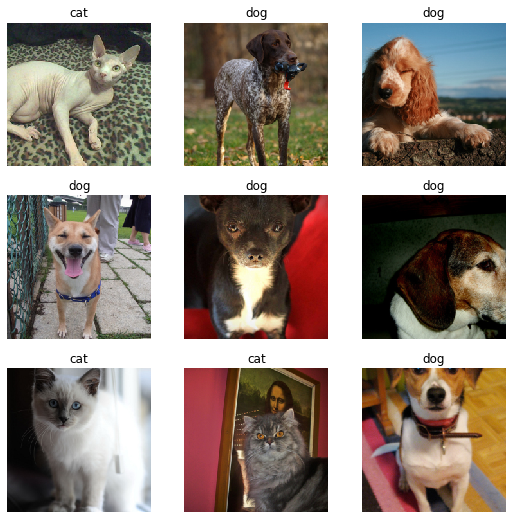

In [ ]:
dls = dblock.dataloaders(path/"images")
dls.show_batch()

The way we usually build the data block in one go is by answering a list of questions:

- what is the types of your inputs/targets? Here images and categories
- where is your data? Here in filenames in subfolders
- does something need to be applied to inputs? Here no
- does something need to be applied to the target? Here the `label_func` function
- how to split the data? Here randomly
- do we need to apply something on formed items? Here a resize
- do we need to apply something on formed batches? Here no

This gives us this design:

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

For two questions that got a no, the corresponding arguments we would pass if the anwser was different would be `get_x` and `batch_tfms`.

## Image classification

Let's begin with examples of image classification problems. There are two kinds of image classification problems: problems with single-label (each image has one given label) or multi-label (each image can have multiple or no labels at all). We will cover those two kinds here.

In [ ]:
from fastai2.vision.all import *

### MNIST (single label)

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of hand-written digits from 0 to 9. We can very easily load it in the data block API by answering the following questions:

- what are the types of our inputs and targets? Black and white images and labels.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? By looking at the grandparent folder.
- how do we know the label of an image? By looking at the parent folder.

In terms of the API, those answers translate like this:

In [ ]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

Our types become blocks: one for images (using the black and white `PILImageBW` class) and one for categories. Searching subfolder for all image filenames is done by the `get_image_files` function. The split training/validation is done by using a `GrandparentSplitter`. And the function to get our targets (often called `y`) is `parent_label`.

To get an idea of the objects the fastai library provides for reading, labelling or splitting, check the `data.transforms` module.

In itself, a data block is just a blueprint. It does not do anything and does not check for errors. You have to feed it the source of the data to actually gather something. This is done with the `.dataloaders` method:

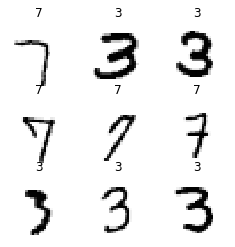

In [ ]:
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

If something went wrong in the previous step, or if you're just curious about what happened under the hood, use the `summary` method. It will go verbosely step by step, and you will see at which point the process failed.

In [ ]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/mnist_tiny/train/3/7861.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /home/sgugger/.fastai/data/mnist_tiny/train/3/7861.png
    applying parent_label gives
      3
    applying Categorize gives
      TensorCategory(0)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(0))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(0))
    applying ToTensor gives
      (TensorImageBW of size 1x28x28, TensorCat

Let's go over another example!

### Pets (single label)

The [Oxford IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) is a dataset of pictures of dogs and cats, with 37 different breeds. A slight (but very) important difference with MNIST is that images are now not all of the same size. In MNIST they were all 28 by 28 pixels, but here they have different aspect ratios or dimensions. Therefore, we will need to add something to make them all the same size to be able to assemble them together in a batch. We will also see how to add data augmentation.

So let's go over the same questions as before and add two more:

- what are the types of our inputs and targets? Images and labels.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By looking at the parent folder.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

And like for MNIST, we can see how the answers to those questions directly translate in the API. Our types become blocks: one for images and one for categories. Searching subfolder for all image filenames is done by the `get_image_files` function. The split training/validation is done by using a `RandomSplitter`. The function to get our targets (often called `y`) is a composition of two transforms: we get the name attribute of our `Path` filenames, then apply a regular expression to get the class. To compose those two transforms into one, we use a `Pipeline`.

Finally, We apply a resize at the item level and `aug_transforms()` at the batch level.

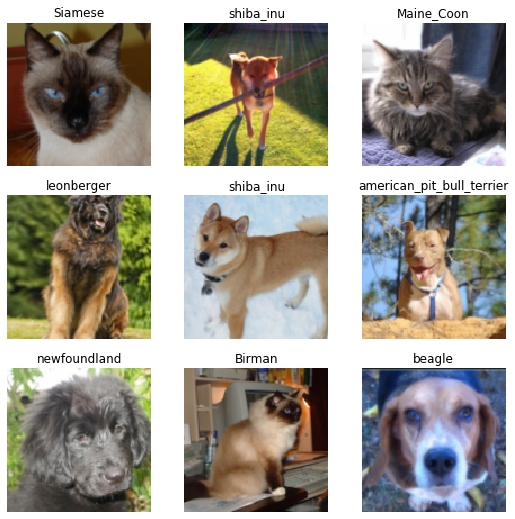

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

Now let's see how we can use the same API for a multi-label problem.

### Pascal (multi-label)

The [Pascal dataset](http://host.robots.ox.ac.uk/pascal/VOC/) is originally an object detection dataset (we have to predict where some objects are in pictures). But it contains lots of pictures with various objects in them, so it gives a great example for a multi-label problem. Let's download it and have a look at the data:

In [ ]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/"train.csv")

In [ ]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


So it looks like we have one column with filenames, one column with the labels (separated by space) and one column that tells us if the filename should go in the validation set or not.

There are multiple ways to put this in a `DataBlock`, let's go over them, but first, let's answer our usual questionnaire:

- what are the types of our inputs and targets? Images and multiple labels.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? A column of our dataframe.
- how do we get an image? By looking at the column fname.
- how do we know the label of an image? By looking at the column labels.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

Notice how there is one more question compared to before: we wont have to use a `get_items` function here because we already have all our data in one place. But we will need to do something to the raw dataframe to get our inputs, read the first column and add the proper folder before the filename. This is what we pass as `get_x`.

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

Again, we can see how the answers to the questions directly translate in the API. Our types become blocks: one for images and one for multi-categories. The split is done by a `ColSplitter` (it defaults to the column named `is_valid`). The function to get our inputs (often called `x`) is a `ColReader` on the first column with a prefix, the function to get our targets (often called `y`) is `ColReader` on the second column, with a space delimiter. We apply a resize at the item level and `aug_transforms()` at the batch level.

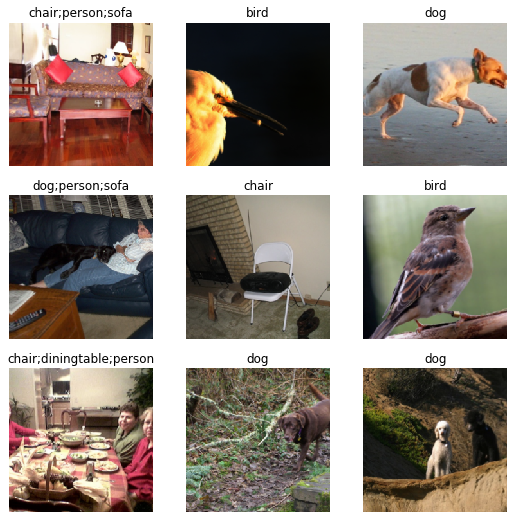

In [ ]:
dls = pascal.dataloaders(df)
dls.show_batch()

Another way to do this is by directly using functions for `get_x` and `get_y`:

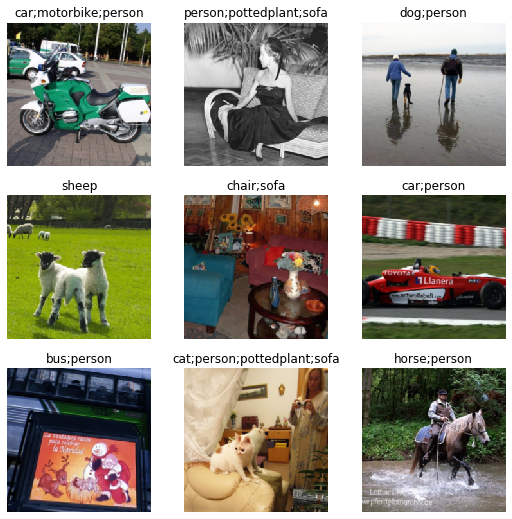

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

Alternatively, we can use the names of the columns as attributes (since rows of a dataframe are pandas series).

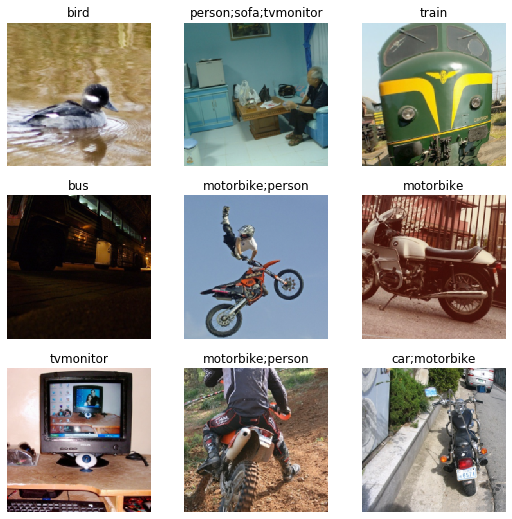

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda o:f'{pascal_source}/train/'+o.fname,
                   get_y=lambda o:o.labels.split(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

The most efficient way (to avoid iterating over the rows of the dataframe, which can take a long time) is to use the `from_columns` method. It will use `get_items` to convert the columns into numpy arrays. The drawback is that since we lose the dataframe after extracting the relevant columns, we can't use a `ColSplitter` anymore. Here we used an `IndexSplitter` after manually extracting the index of the validation set from the dataframe:

In [ ]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())
valid_idx = df[df['is_valid']].index.values

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

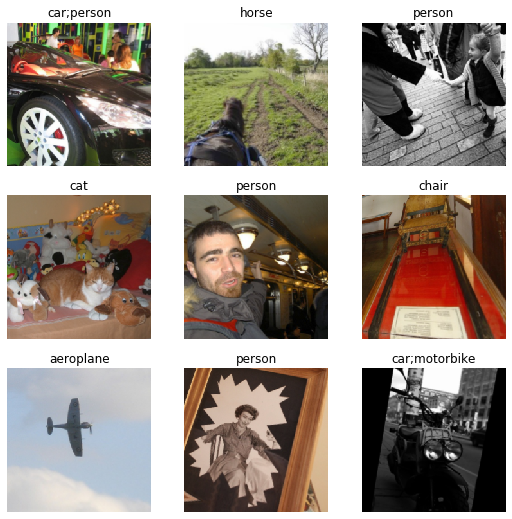

In [ ]:
dls = pascal.dataloaders(df)
dls.show_batch()

## Image localization

There are various problems that fall in the image localization category: image segmentation (which is a task where you have to predict the class of each pixel of an image), coordinate predictions (predict one or several key points on an image) and object detection (draw a box around objects to detect).

Let's see an example of each of those and how to use the data block API in each case.

### Segmentation

We will use a small subset of the [CamVid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) for our example.

In [ ]:
path = untar_data(URLs.CAMVID_TINY)

Let's go over our usual questionnaire:

- what are the types of our inputs and targets? Images and segmentation masks.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By looking at a corresponding file in the "labels" folder.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

The `MaskBlock` is generated with the `codes` that give the correpondence between pixel value of the masks and the object they correspond to (like car, road, pedestrian...). The rest should look pretty familiar by now.

/opt/conda/conda-bld/pytorch_1585984269458/work/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


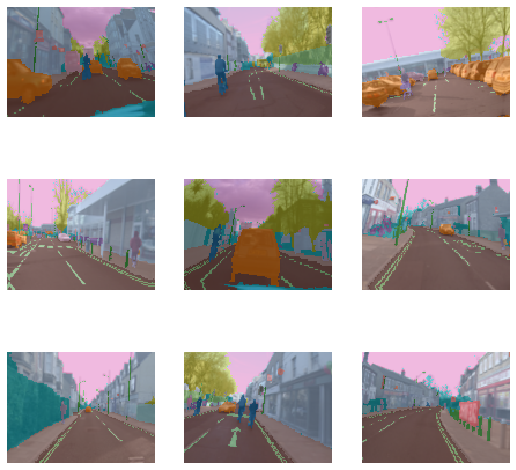

In [ ]:
dls = camvid.dataloaders(path/"images")
dls.show_batch()

### Points

For this example we will use a small sample of the [BiWi kinect head pose dataset](https://www.kaggle.com/kmader/biwi-kinect-head-pose-database). It contains pictures of people and the task is to predict where the center of their head is. We have saved this small dataet with a dictionary filename to center:

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (biwi_source/'centers.pkl').load()

Then we can go over our usual questions:

- what are the types of our inputs and targets? Images and points.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By using the `fn2ctr` dictionary.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

And we can use it to create a `DataLoaders`:

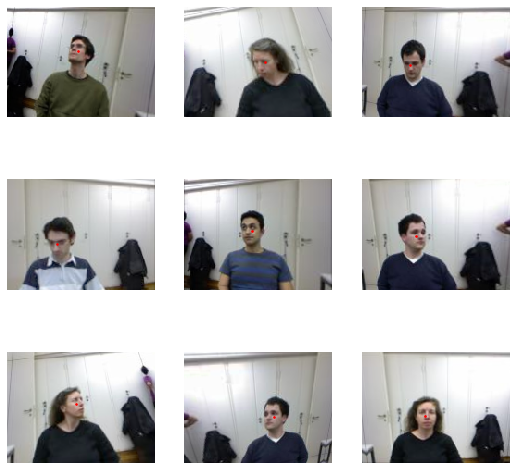

In [ ]:
dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)

### Bounding boxes

For this task, we will use a small subset of the [COCO dataset](http://cocodataset.org/#home). It contains pictures with day-to-day objects and the goal is to predict where the objects are by drawing a rectangle around them. 

The fastai library comes with a function called `get_annotations` that will interpret the content of `train.json` and give us a dictionary filename to (bounding boxes, labels).

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

Then we can go over our usual questions:

- what are the types of our inputs and targets? Images and bounding boxes.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By using the `img2bbox` dictionary.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

Note that we provide three types, because we have two targets: the bounding boxes and the labels. That's why we pass `n_inp=1` at the end, to tell the library where the inputs stop and the targets begin.

This is also why we pass a list to `get_y`: since we have two targets, we must tell the library how to label for each of them (you can use `noop` if you don't want to do anything for one).

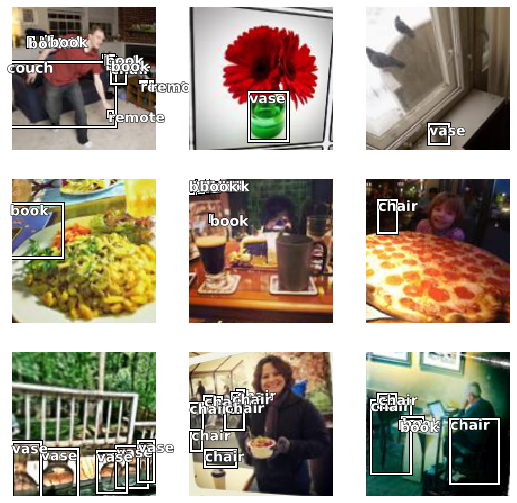

In [ ]:
dls = coco.dataloaders(coco_source)
dls.show_batch(max_n=9)

## Text

We will show two examples: language modeling and text classification. Note that with the data block API, you can adapt the example before for multi-label to a problem where the inputs are texts.

In [ ]:
from fastai2.text.all import *

### Language model

We will use a dataset compose of movie reviews from IMDb. As usual, we can download it in one line of code with `untar_data`.

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


We can see it's composed of (pretty long!) reviews labeled positive or negative. Let's go over our usual questions:

- what are the types of our inputs and targets? Texts and we don't really have targets, since the targets is derived from the inputs.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? We have an `is_valid` column.
- how do we get our inputs? In the `text` column.

In [ ]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

Since there are no targets here, we only have one block to specify. `TextBlock`s are a bit special compared to other `TransformBlock`s: to be able to efficiently tokenize all texts during setup, you need to use the class methods `from_folder` or `from_df`.

We can then get our data into `DataLoaders` by passing the dataframe to the `dataloaders` method:

In [ ]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)
dls.show_batch(max_n=6)

,text,text_
0,"xxbos xxmaj ah , a xxmaj kelly / xxmaj sinatra sailor - suit musical . xxmaj so familiar , right ? xxmaj yes , but this is n't the one you usually hear about . xxmaj on xxmaj the xxmaj town 's that - a - way . xxmaj but if you stick around , you might learn something . xxmaj okay , probably not . xxmaj anyway , xxmaj xxunk xxmaj","xxmaj ah , a xxmaj kelly / xxmaj sinatra sailor - suit musical . xxmaj so familiar , right ? xxmaj yes , but this is n't the one you usually hear about . xxmaj on xxmaj the xxmaj town 's that - a - way . xxmaj but if you stick around , you might learn something . xxmaj okay , probably not . xxmaj anyway , xxmaj xxunk xxmaj xxunk"
1,"made , but it 's a definite xxunk . xxmaj troma should have let this film rot instead of giving it a release . xxmaj do n't make the same mistake i did and let your curiosity get the best of you . \n\n xxmaj my rating : 1 / 5 xxbos xxmaj this movie had good intentions and a good story to work with . xxmaj the director and screenwriter of",", but it 's a definite xxunk . xxmaj troma should have let this film rot instead of giving it a release . xxmaj do n't make the same mistake i did and let your curiosity get the best of you . \n\n xxmaj my rating : 1 / 5 xxbos xxmaj this movie had good intentions and a good story to work with . xxmaj the director and screenwriter of this"
2,"older brother , xxmaj count xxmaj igor xxmaj xxunk was horribly burned and killed in a lab accident . \n\n xxmaj then a woman xxmaj xxunk ( xxunk xxmaj xxunk ) that xxmaj igor hired before his death to xxunk him in his xxunk shows up . xxmaj yanos agrees to hire her in place of his brother and together they seek the xxunk for the xxunk of dead xxunk . xxmaj","brother , xxmaj count xxmaj igor xxmaj xxunk was horribly burned and killed in a lab accident . \n\n xxmaj then a woman xxmaj xxunk ( xxunk xxmaj xxunk ) that xxmaj igor hired before his death to xxunk him in his xxunk shows up . xxmaj yanos agrees to hire her in place of his brother and together they seek the xxunk for the xxunk of dead xxunk . xxmaj yanos"
3,". xxmaj but the fact is that it is a superb xxunk of the life of the xxmaj xxunk . xxmaj jim xxmaj jones , who built a church into a virtual empire , and then encouraged it to xxunk into a sleazy cult in which a xxmaj xxunk and his xxunk were xxunk , and xxunk cult xxunk committed suicide by drinking xxunk - aid xxunk with xxunk . \n\n xxmaj","xxmaj but the fact is that it is a superb xxunk of the life of the xxmaj xxunk . xxmaj jim xxmaj jones , who built a church into a virtual empire , and then encouraged it to xxunk into a sleazy cult in which a xxmaj xxunk and his xxunk were xxunk , and xxunk cult xxunk committed suicide by drinking xxunk - aid xxunk with xxunk . \n\n xxmaj done"
4,"tears they shed . xxbos great mystery , but the film goes down hill from there . xxmaj the beginning is promising with a car wreck and a woman and her daughter being burned alive in front of a police officer , xxmaj edward . xxmaj he is xxunk over this and is seen popping pills . a mysterious letter turns up from an old girlfriend asking for help in finding her","they shed . xxbos great mystery , but the film goes down hill from there . xxmaj the beginning is promising with a car wreck and a woman and her daughter being burned alive in front of a police officer , xxmaj edward . xxmaj he is xxunk over this and is seen popping pills . a mysterious letter turns up from an old girlfriend asking for help in finding her missing"
5,"and daring to show the xxunk of certain aspects of city life . xxbos i was looking forward to xxmaj kathryn xxmaj xxunk 's movie with great anticipation after the endless hype and 6 xxmaj xxunk which it was xxunk . xxmaj unfortunately it really is n't a good movie . xxmaj the depiction of the situation certainly seemed to be accurate and believable on all counts , but beyond that the","daring to show the xxunk of certain aspects of city life . xxbos i was looking forw

### Text classification

For the text classification, let's go over our usual questions:

- what are the types of our inputs and targets? Texts and categories.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? We have an `is_valid` column.
- how do we get our inputs? In the `text` column.
- how do we get our targets? In the `label` clolumn.

In [ ]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter())

Like in the previous example, we use a class method to build a `TextBlock`. We can pass it the vocabulary of our language model (very useful for the ULMFit approach). We also show the `seq_len` argument (which defaults to 72) just because you need to make sure to use the same here and also in your `text_classifier_learner`.

> Warning: You need to make sure to use the same `seq_len` in `TextBlock` and the `Learner` you will define later on.

In [ ]:
dls = imdb_clas.dataloaders(df, bs=64)
dls.show_batch()

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present , almost diabolical",negative
3,"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" la xxmaj xxunk , "" based on a play by xxmaj arthur xxmaj xxunk , who is given an "" inspired by "" credit . xxmaj it starts from one person , a prostitute , standing on a street corner in xxmaj brooklyn . xxmaj she is picked up by a home contractor , who has sex with her on the hood of a car , but ca n't come . xxmaj he refuses to pay her . xxmaj when he 's off xxunk , she",positive
4,"xxbos i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . xxmaj the only problem is half of them are straight and xxmaj james does n't know this . xxmaj if xxmaj james picks a gay one , they get a trip to xxmaj new xxmaj zealand , and xxmaj if he picks a straight one , straight guy gets $ 25 , xxrep 3 0 . xxmaj how can this not be fun",negative
5,"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gami

## Tabular data

Tabular data doesn't really use the data block API as it's relying on another API with `TabularPandas` for efficient preprocessing and batching (there will be some less efficient API that plays nicely with the data block API added in the near future). You can still use different blocks for the targets. 

In [ ]:
from fastai2.tabular.core import *

For our example, we will look at a subset of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) which contains some census data and where the task is to predict if someone makes more than 50k or not.

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In a tabular problem, we need to split the columns between the ones that represent continuous variables (like the age) and the ones that represent categorical variables (like the education):

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

Standard preprocessing in fastai, use those pre-processors: 

In [ ]:
procs = [Categorify, FillMissing, Normalize]

`Categorify` will change the categorical columns into indices, `FillMissing` will fill the missing values in the continuous columns (if any) and add an na categorical column (if necessary). `Normalize` will normalize the continous columns (substract the mean and divide by the standard deviation).

We can still use any splitter to create the splits as we'd like them:

In [ ]:
splits = RandomSplitter()(range_of(df))

And then everything goes in a `TabularPandas` object:

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits, y_block=CategoryBlock)

We put `y_block=CategoryBlock` just to show you how to customize the block for the targets, but it's usually inferred from the data, so you don't need to pass it, normally.

In [ ]:
dls = to.dataloaders()
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,61.000000,215591.000525,9.0,>=50k
1,Private,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,False,33.000000,115496.003013,16.0,>=50k
2,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,False,51.000000,74275.001507,9.0,<50k
3,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,False,65.000000,85787.002422,4.0,<50k
4,Local-gov,HS-grad,Never-married,Transport-moving,Own-child,White,False,29.000000,179680.999669,9.0,<50k
5,Private,9th,Divorced,Transport-moving,Not-in-family,White,False,50.000000,22418.004892,5.0,<50k
6,?,12th,Divorced,?,Not-in-family,White,False,62.000001,223447.000766,8.0,<50k
7,Private,Masters,Separated,Machine-op-inspct,Unmarried,Asian-Pac-Islander,False,47.000000,334678.999849,14.0,<50k
8,Private,Some-college,Never-married,Machine-op-inspct,Own-child,White,False,25.000000,103358.001091,10.0,<50k
9,Private,HS-grad,Divorced,Prof-specialty,Not-in-family,White,False,56.000000,168625.000206,9.0,<50k
